# Testing the Wong solver for a single Glasma event

## Glasma simulation parameters

In [1]:
import numpy as np

# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# General parameters
su_group = 'su3'        # Gauge group

# Simulation box parameters
L = 10      # Length of simulation box [fm]
N = 512     # Number of lattice sites
tau_sim = 1.0     # Simulation time [fm/c]
DTS = 8     # Time step
# Derived parameters
dt = 1.0 / DTS          # Leapfrog time step
a = L / N           # Lattice spacing
E0 = 1 / a * hbarc          # Energy scale [GeV]

# MV model parameters
Qs = 2              # Saturation momentum [GeV]	
ns = 50     # Number of color sheets
factor = 0.8        # Ratio between Qs/g^2\mu for Ns = 50 color sheets
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))           # Running coupling constant		
mu = Qs / (g**2 * factor)           # MV model parameter	
ir = 0.1 * g**2 * mu         # Infrared regulator [GeV]
uv = 10.0           # Ultraviolet regulator [GeV]

## Wong solver simulation parameters

In [2]:
# Parameters related to a specific quark
# mass = 1.27      # Charm quark mass [GeV]
mass = 1000
tau_form = 1/(2*mass)*hbarc     # Formation time [fm/c]
pT = 0.5    # Initial transverse momentum [GeV]
ntp = 1000   # Number of test particles

## Seting environment variables & importing all relevant modules

In [3]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
# Wong modules
from curraun import wong
wong.DEBUG = True
wong.REPRESENTATION = 'fundamental'
wong.BOUNDARY = 'periodic'
from curraun.wong import init_charge
# Kappa module
import curraun.kappa as kappa

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


## Initializing the Glasma fields

In [4]:
s = core.Simulation(N, dt, g)
va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
initial.init(s, va, vb)

## Initializaing the Wong solver

In [5]:
wong_solver = wong.WongSolver(s, ntp)

# Initialize the Wong solver
wong_solver = wong.WongSolver(s, ntp)

# Transverse momentum in lattice units
pT /= E0
# Store all initial positions, momenta and color charges
x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 4)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
# Mass in lattice units
mass /= E0
m = mass * np.ones(ntp)

# Loop over all test particles
for i in range(ntp):
    # Random position in the transverse plane, null \eta
    xT = np.random.rand(2) * s.n
    x0 = [xT[0], xT[1], 0.0]
    # Random transverse momentum, null p^\eta
    angle = 2*np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0]
    # Random color charge
    q0 = init_charge()

    x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

wong_solver.initialize(x0s, p0s, q0s, m)

## Evolving the Glasma fields & solving Wong's equations

In [6]:
t_max = int(tau_sim / a * DTS)

# position, momentum and charge history
xs = np.zeros((t_max, ntp, 3))
ps = np.zeros((t_max, ntp, 4))
qs = np.zeros((t_max, ntp, su.GROUP_ELEMENTS))

if wong.DEBUG:
    cs = np.zeros((t_max, ntp, su.CASIMIRS))

if use_cuda:
    s.copy_to_device()
    wong_solver.copy_to_device()
        
for t in range(t_max):
    core.evolve_leapfrog(s)
    wong_solver.evolve()
    if wong.DEBUG:
        wong_solver.compute_casimirs()
        cs[t] = wong_solver.c.copy()
    xs[t] = wong_solver.x0.copy()
    ps[t] = wong_solver.p.copy()
    qs[t] = wong_solver.q.copy()
    # actives[t] = wong_solver.active.copy()
    # if (wong_solver.active.copy()==0).sum()!=0:
    #     deactivated_index = np.where(wong_solver.active.copy()==0)[0]
    #     print('index=', deactivated_index[0])
    #     print('p[index]=', wong_solver.p.copy()[deactivated_index[0], :])

    # fcorr.compute_lorentz_force()
    # if t==0:
    #     f0 = fcorr.f.copy()
    # f = fcorr.f.copy()
    # w = wong_solver.w.copy()
    # fcorr.compute_lorentz_force_correlator(f0, f, w)
    # corr[t] = fcorr.corr.copy()

    # fs[t] = wong_solver.f.copy()
    # ws[t] = wong_solver.w.copy()

# plotting trajectories

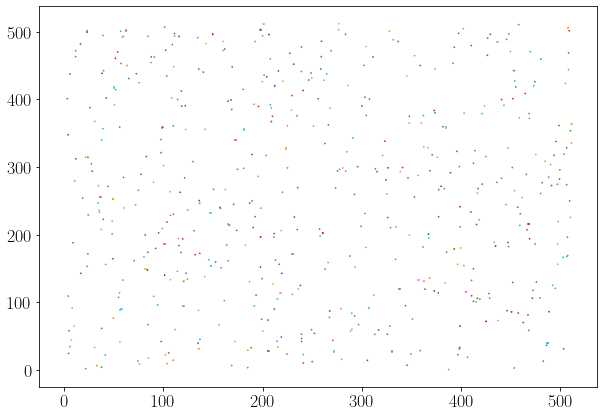

In [7]:
import matplotlib.pyplot as plt

from matplotlib import rc
rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

for i in range(ntp):
    plt.plot(xs[:, i, 0], xs[:, i, 1])

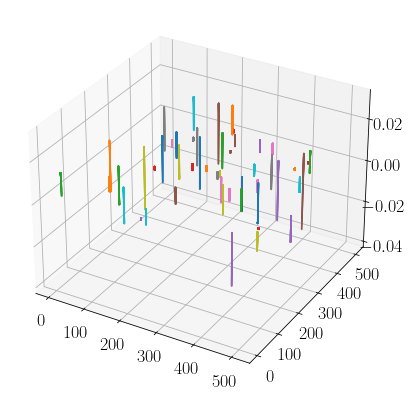

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(ntp//20):
    ax.scatter(xs[:, i, 0], xs[:, i, 1], xs[:, i, 2], xs[:, i, 2], s=0.5)

# quadratic and cubic casimirs check

[1.33333645 1.11111396]


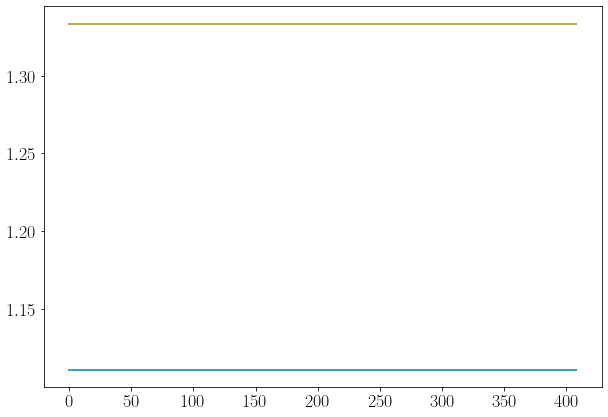

In [16]:
print(cs[1,1,:])
for i in range(ntp):
    for ci in range(su.CASIMIRS):
        plt.plot(range(t_max), cs[:, i, ci])
# range for SU(2)
# plt.ylim([0.6, 0.9])

# plot momentum and position variance

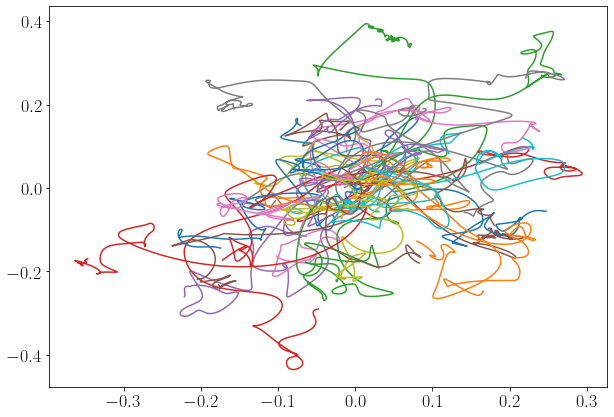

In [9]:
for i in range(ntp//20):
    plt.plot(ps[:, i, 1], ps[:, i, 2])

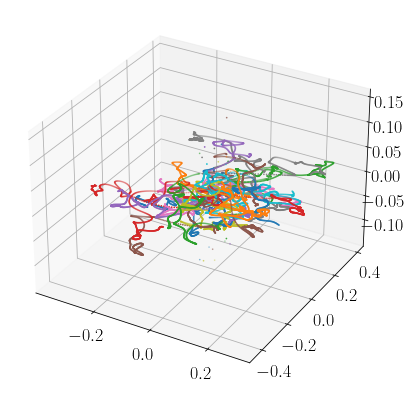

In [11]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')
for i in range(ntp//20):
    ax.scatter(ps[:, i, 1], ps[:, i, 2], ps[:, i, 3], ps[:, i, 3], s=0.5)

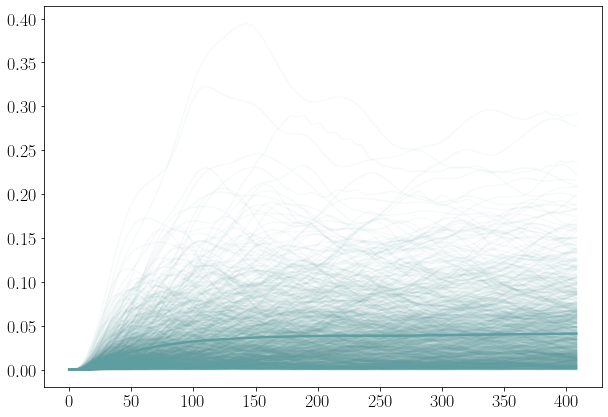

In [12]:
sigmapts = []
for i in range(ntp):
    sigmapt = (ps[:, i, 1]-ps[0, i, 1])**2 + (ps[:, i, 2]-ps[0, i, 2])**2
    plt.plot(range(t_max), sigmapt, alpha=0.05, color="cadetblue")
    sigmapts.append(sigmapt)
sigmap_mean = np.mean(sigmapts, axis=0)
plt.plot(range(t_max), sigmap_mean, color="cadetblue", linewidth=2.5)

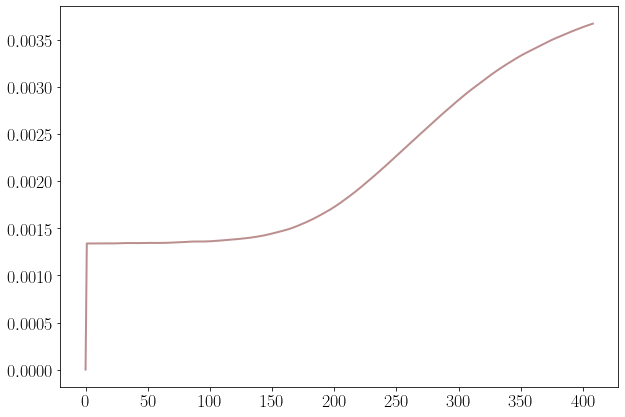

In [28]:
sigmapetas = []
for i in range(ntp):
    sigmapeta = (ps[:, i, 3]-ps[0, i, 3])**2 
    # plt.plot(range(t_max), sigmapeta, alpha=0.05, color="rosybrown")
    sigmapetas.append(sigmapeta)
sigmapeta_mean = np.mean(sigmapetas, axis=0)
plt.plot(range(t_max), sigmapeta_mean, color="rosybrown", linewidth=2.)

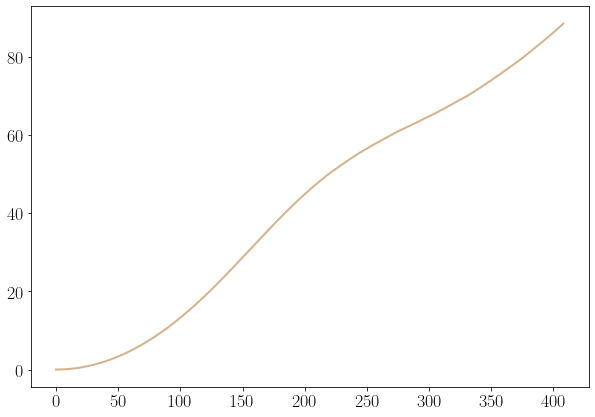

In [27]:
sigmapzs = []
times = np.linspace(0, t_max-1, t_max)
for i in range(ntp):
    # pz0 = ps[0, i, 0]*np.sinh(xs[0, i, 2]) + range(t_max)[0]*ps[0, i, 3]*np.cosh(xs[0, i, 2])
    # pz = ps[:, i, 0]*np.sinh(xs[:, i, 2]) + range(t_max)*ps[:, i, 3]*np.cosh(xs[:, i, 2])
    # sigmapz = (pz-pz0)**2
    sigmapz = np.square(np.multiply(times, ps[:, i, 3]))
    # plt.plot(range(t_max), sigmapz, alpha=0.05, color="tan")
    sigmapzs.append(sigmapz)
sigmapz_mean = np.mean(sigmapzs, axis=0)
plt.plot(range(t_max), sigmapz_mean, color="tan", linewidth=2.)

In [ ]:
sigmaxs = []
for i in range(n_particles//20):
    sigmax = (xs[:, i, 0]-xs[0, i, 0])**2 + (xs[:, i, 1]-xs[0, i, 1])**2
    plt.plot(range(t_max), sigmax, alpha=0.05, color="darkseagreen")
    sigmaxs.append(sigmax)
sigmax_mean = np.mean(sigmaxs, axis=0)
plt.plot(range(t_max), sigmax_mean, color="darkseagreen", linewidth=2.)

# lorentz force correlators

In [ ]:
fig, ax = plt.subplots()

corr_avg = np.mean(corr, axis=1)
corr_sum = corr_avg[:, 0]+corr_avg[:, 1]+corr_avg[:, 2]

# [(GeV / fm) ** 2]
units = (E0 ** 2 / hbarc) ** 2 / g ** 2

plt.plot(range(t_max), corr_sum*units)
# labels = [r'$\langle\mathcal{F}_x\mathcal{F}_x\rangle$', r'$\langle\mathcal{F}_y\mathcal{F}_y\rangle$', r'$\langle\mathcal{F}_\eta \mathcal{F}_\eta\rangle$']
# for i in range(3):
#     ax.plot(range(t_max), corr_avg[:, i], label=labels[i])
# ax.legend()

# ax.set_xscale('log')
# ax.set_yscale('log')

# lorentz force autocorrelation

In [ ]:
autocorrelator = np.zeros((t_max, n_particles, 3))

for t0 in range(t_max):
    autocorr_t = np.zeros((n_particles, 3))
    for deltat in range(t_max-t0):
        t1 = t0 + deltat
        wong_solver.compute_lorentz_force_autocorrelator(fs[t0, :, :, :], fs[t1, :, :, :], ws[t0, :, :], ws[t1, :, :])
        autocorr_t += wong_solver.auto_corr.copy()
    autocorrelator[t0, :, :] = autocorr_t

autocorr_avg = np.mean(autocorrelator, axis=1)
labels = [r'$\langle\mathcal{F}_x\mathcal{F}_x\rangle$', r'$\langle\mathcal{F}_y\mathcal{F}_y\rangle$', r'$\langle\mathcal{F}_\eta \mathcal{F}_\eta\rangle$']
for i in range(3):
    ax.plot(range(t_max), autocorr_avg[:, i], label=labels[i])
ax.legend()

# run kappa.py

In [29]:
import curraun.kappa as kappa
from tqdm.notebook import tqdm

all_px, all_py, all_pz = [], [], []

Nevents = 10

outer_loop=tqdm(range(Nevents), desc="Event", position=0)
inner_loop=tqdm(range(t_max), desc="Time", position=1)

for e in range(len(outer_loop)):
        s = core.Simulation(N, dt, g)
        va = mv.wilson(s, mu=mu/E0, m=m/E0, uv=uv/E0, num_sheets=ns)
        vb = mv.wilson(s, mu=mu/E0, m=m/E0, uv=uv/E0, num_sheets=ns)
        initial.init(s, va, vb)
        
        kappa_tforce = kappa.TransportedForce(s)
        px, py, pz = [], [], []

        if use_cuda:
            s.copy_to_device()
            kappa_tforce.copy_to_device()
        
        for t in range(len(inner_loop)):
                core.evolve_leapfrog(s)
                
                if use_cuda:
                    kappa_tforce.copy_mean_to_host()

                px.append(kappa_tforce.p_perp_mean[0])
                py.append(kappa_tforce.p_perp_mean[1])
                pz.append(kappa_tforce.p_perp_mean[2]) 
                
                if use_cuda:
                    kappa_tforce.copy_mean_to_device()

                kappa_tforce.compute()
                inner_loop.update()
        
        all_px.append(px)
        all_py.append(py)
        all_pz.append(pz)

        if (e+1)<len(outer_loop):
            inner_loop.refresh()  
            inner_loop.reset()
        outer_loop.update()

px_mean, py_mean, pz_mean = np.mean(all_px, axis=0), np.mean(all_py, axis=0), np.mean(all_pz, axis=0)

Event:   0%|          | 0/10 [00:00<?, ?it/s]

Time:   0%|          | 0/409 [00:00<?, ?it/s]

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<numba.cuda.compiler.DeviceFunctionTemplate object at 0x7fca873dd978>) with argument(s) of type(s): (int32, array(float64, 1d, C), int64, int64, float64, array(float64, 2d, A))
 * parameterized
In definition 0:
    TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function pow>) with argument(s) of type(s): (array(float64, 1d, C), Literal[int](2))
Known signatures:
 * (int64, int64) -> int64
 * (int64, uint64) -> int64
 * (uint64, int64) -> int64
 * (uint64, uint64) -> uint64
 * (float32, int32) -> float32
 * (float32, int64) -> float32
 * (float32, uint64) -> float32
 * (float64, int32) -> float64
 * (float64, int64) -> float64
 * (float64, uint64) -> float64
 * (float32, float32) -> float32
 * (float64, float64) -> float64
 * (complex64, complex64) -> complex64
 * (complex128, complex128) -> complex128
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of intrinsic-call at ../curraun/mv.py (143)

File "../curraun/mv.py", line 143:
def wilson_compute_poisson_kernel(x, mass, n, new_n, uv, kernel):
    <source elided>
        if (x > 0 or y > 0) and k2 <= uv ** 2:
            kernel[x, y] = 1.0 / (k2 + mass ** 2)
            ^

    raised from /home/dana/anaconda3/envs/curraun/lib/python3.6/site-packages/numba/typeinfer.py:985
In definition 1:
    TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function pow>) with argument(s) of type(s): (array(float64, 1d, C), Literal[int](2))
Known signatures:
 * (int64, int64) -> int64
 * (int64, uint64) -> int64
 * (uint64, int64) -> int64
 * (uint64, uint64) -> uint64
 * (float32, int32) -> float32
 * (float32, int64) -> float32
 * (float32, uint64) -> float32
 * (float64, int32) -> float64
 * (float64, int64) -> float64
 * (float64, uint64) -> float64
 * (float32, float32) -> float32
 * (float64, float64) -> float64
 * (complex64, complex64) -> complex64
 * (complex128, complex128) -> complex128
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of intrinsic-call at ../curraun/mv.py (143)

File "../curraun/mv.py", line 143:
def wilson_compute_poisson_kernel(x, mass, n, new_n, uv, kernel):
    <source elided>
        if (x > 0 or y > 0) and k2 <= uv ** 2:
            kernel[x, y] = 1.0 / (k2 + mass ** 2)
            ^

    raised from /home/dana/anaconda3/envs/curraun/lib/python3.6/site-packages/numba/typeinfer.py:985
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<numba.cuda.compiler.DeviceFunctionTemplate object at 0x7fca873dd978>)
[2] During: typing of call at <string> (4)


File "<string>", line 4:
<source missing, REPL/exec in use?>


In [ ]:
sigmap_kappa = px_mean + py_mean
plt.plot(range(t_max), sigmap_kappa, label='kappa', color="slateblue")
plt.plot(range(t_max), sigmap_mean, label='wong', color="cadetblue")
plt.legend(loc="upper left")
plt.title('SU(2)')
# plt.title('SU(3)')
# plt.ylim(0, 0.02)

In [ ]:
sigmapz_kappa = pz_mean
plt.plot(range(t_max), sigmapz_kappa, label='kappa', color="slateblue")
# plt.plot(range(t_max), sigmapz_mean, label='wong', color="cadetblue")
plt.legend(loc="upper left")
plt.title('SU(2)')
# plt.title('SU(3)')
# plt.ylim(0, 0.05)